In [1]:
import fastai

fastai.__version__

'1.0.61'

In [2]:
!pip install fastai -Uqq

     |████████████████████████████████| 194kB 12.4MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 


In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [7]:
img_files = get_image_files(path)
# getting only image files
img_files

(#15678) [Path('05/frame_00607_rgb.jpg'),Path('05/frame_00417_rgb.jpg'),Path('05/frame_00293_rgb.jpg'),Path('05/frame_00097_rgb.jpg'),Path('05/frame_00032_rgb.jpg'),Path('05/frame_00927_rgb.jpg'),Path('05/frame_00838_rgb.jpg'),Path('05/frame_00811_rgb.jpg'),Path('05/frame_00497_rgb.jpg'),Path('05/frame_00196_rgb.jpg')...]

In [8]:
def img2pos(x):
  return Path(f'{str(x)[:-7]}pose.txt')

img2pos(img_files[0])

Path('05/frame_00607_pose.txt')

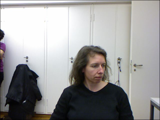

In [9]:
im = PILImage.create(img_files[0])
im.to_thumb(160)

In [10]:
# function to get the heads center
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pos(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
get_ctr(img_files[0])

# givesth eposition

tensor([393.8586, 269.4543])

In [12]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),get_items=get_image_files, #this gives tou the x basically
                 get_y=get_ctr, splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms= [*aug_transforms(size=(240,320)),
                              Normalize.from_stats(*imagenet_stats)]
                 )


# things I don't get here are splitter how is funcsplitter working, and get_items

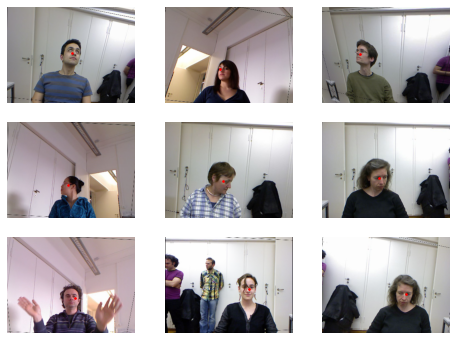

In [13]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [14]:
# look at ne batch

xb, yb = dls.one_batch()
xb.shape, yb.shape

((64, 3, 240, 320), (64, 1, 2))

In [15]:
yb

TensorPoint([[[ 0.0592, -0.1327]],

        [[-0.0025, -0.0431]],

        [[-0.0932,  0.2498]],

        [[ 0.3039,  0.3009]],

        [[-0.0407,  0.1043]],

        [[-0.1179, -0.0153]],

        [[-0.2732,  0.1230]],

        [[-0.3337,  0.1367]],

        [[-0.0206,  0.0514]],

        [[-0.3820,  0.0711]],

        [[-0.1525,  0.0814]],

        [[ 0.0490,  0.0502]],

        [[ 0.1175,  0.1683]],

        [[ 0.2186,  0.1581]],

        [[ 0.0823,  0.0992]],

        [[ 0.1204,  0.0362]],

        [[ 0.0576,  0.4390]],

        [[-0.1106,  0.0195]],

        [[-0.1017,  0.2188]],

        [[-0.2699,  0.0111]],

        [[-0.5170,  0.1592]],

        [[-0.1100,  0.2007]],

        [[-0.1432, -0.1534]],

        [[ 0.0672,  0.0454]],

        [[ 0.2077,  0.2571]],

        [[-0.1631,  0.1931]],

        [[-0.0627,  0.0344]],

        [[-0.0031,  0.1276]],

        [[-0.1488,  0.2522]],

        [[ 0.1366, -0.2131]],

        [[-0.1532,  0.3293]],

        [[ 0.2739,  0.1621]],

   

In [16]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
# yrange is used to define the target space max and min value

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [17]:
# yrange is nothing but sigmoid range


def sigmoid_range(x, lo,hi):
  return torch.sigmoid(x) * (hi-lo) +lo

In [18]:
!pip install utils

# plot function not working

In [19]:
try:
  from utils import plot_function
except Exception as e:
  print(e)
# utils not part of plot_function

# https://forums.fast.ai/t/lesson-6-plot-function-is-not-defined/69667/4

cannot import name 'plot_function'


In [20]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  


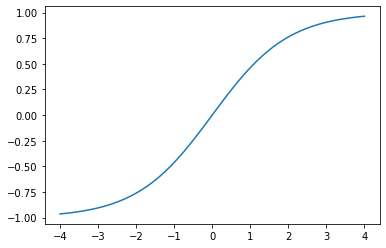

In [21]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [22]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.03981071710586548)

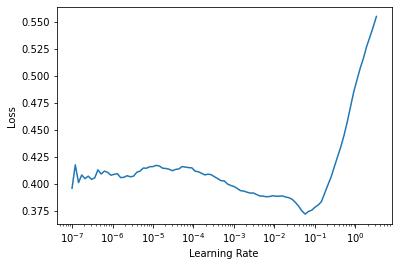

In [23]:
learn.lr_find()

In [24]:
lr =1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047860,0.008638,01:58


epoch,train_loss,valid_loss,time
0,0.007848,0.003260,02:06
1,0.002981,0.000555,02:06
2,0.001547,0.000126,02:08


In [25]:
math.sqrt(0.0001)

0.01

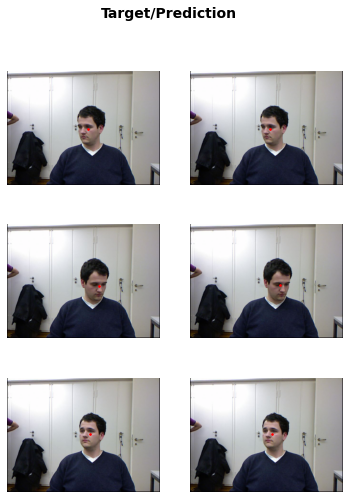

In [26]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))